# Legendre Memory Units

In [7]:
%reset -f

## Imports

In [8]:
import random
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm
from matplotlib import pyplot as plt

from torchlmu import LMUFFT

def setSeed(seed):
    """ Set all seeds to ensure reproducibility """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

In [9]:
temp = LMUFFT(1, 2, 100, 200, 10, 10)
rand_in = torch.rand(1, 10, 1)
out = temp(rand_in)

In [10]:
SEED = 0
INPUT_DIM = 1    # Dimension of the input, a single pixel
MEM_D = 1        # Dimension of the memory
SEQ_LEN = 784    # Sequence length
THETA = 784      # Length of the memory window (used in determining the LMU parameters)
HIDDEN_DIM = 346 # Dimension of the hidden state
ORDER = 468      # Order/Size (Legendre Coefficients) of the memory
NUM_CLASSES = 10 # Number of classes
BATCH_SIZE = 100 # Batch size
EPOCHS = 10      # Number of epochs

# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted 
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"

setSeed(SEED)

In [11]:
class psMNIST(Dataset):
    """ Dataset that defines the psMNIST dataset, given the MNIST data and a fixed permutation """

    def __init__(self, mnist, perm):
        self.mnist = mnist # also a torch.data.Dataset object
        self.perm  = perm

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        unrolled = img.reshape(-1)
        permuted = unrolled[self.perm]
        permuted = permuted.reshape(-1, 1)
        return permuted, label

class Model(nn.Module):
    """ A simple model for the psMNIST dataset consisting of a single LMUFFT layer and a single dense classifier """

    def __init__(self, input_size, output_size, hidden_size, memory_d, order, seq_len, theta):
        super(Model, self).__init__()
        self.lmu_fft = LMUFFT(input_size, memory_d, order, hidden_size, seq_len, theta)
        self.dropout = nn.Dropout(p = 0.5)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h_n = self.lmu_fft(x) # [batch_size, hidden_size]
        x = self.dropout(h_n)
        output = self.classifier(x)
        return output # [batch_size, output_size]

In [12]:
def disp(img):
    """ Displays an image """
    if len(img.shape) == 3:
        img = img.squeeze(0)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def dispSeq(seq, rows = 8):
    """ Displays a sequence of pixels """
    seq = seq.reshape(rows, -1) # divide the 1D sequence into `rows` rows for easy visualization
    disp(seq)

def countParameters(model):
    """ Counts and prints the number of trainable and non-trainable parameters of a model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

def accuracy_score(y_true, y_pred):
    """ Computes the accuracy of the predictions """
    return np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

#### Model

In [13]:
def train(model, loader, optimizer, criterion):
    """ A single training epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.train()
    progress_bar = tqdm(loader)
    for batch, labels in progress_bar:

        torch.cuda.empty_cache()

        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)

        optimizer.zero_grad()

        output = model(batch)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        preds  = output.argmax(dim = 1)
        preds_list = preds.tolist()
        labels_list = labels.tolist()
        y_pred += preds_list
        y_true += labels_list
        epoch_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}, Acc: {accuracy_score(labels_list, preds_list):.4f}")

    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [14]:
def validate(model, loader, criterion):
    """ A single validation epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(loader):

            torch.cuda.empty_cache()

            batch = batch.to(DEVICE)
            labels = labels.long().to(DEVICE)

            output = model(batch)
            loss = criterion(output, labels)
            
            preds  = output.argmax(dim = 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()
            epoch_loss += loss.item()
            
    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [15]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST("", train = True, download = True, transform = transform)
mnist_val   = datasets.MNIST("", train = False, download = True, transform = transform)

perm = torch.load("permutation.pt").long() # created using torch.randperm(784)
ds_train = psMNIST(mnist_train, perm)
ds_val   = psMNIST(mnist_val, perm)

dl_train = DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True)
dl_val   = DataLoader(ds_val, batch_size = BATCH_SIZE, shuffle = True)

Label: 5


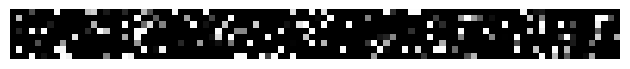

In [16]:
# Example of the data
eg_img, eg_label = ds_train[0]
print("Label:", eg_label)
dispSeq(eg_img)

#### Model

In [17]:
model = Model(
    input_size = INPUT_DIM, 
    output_size = NUM_CLASSES,
    hidden_size = HIDDEN_DIM,  
    memory_d = MEM_D,
    order = ORDER,
    seq_len = SEQ_LEN, 
    theta = THETA
)
model = model.to(DEVICE)
countParameters(model) # should be 166,092 trainable parameters, 0 frozen parameters

The model has 166,092 trainable parameters and 0 frozen parameters


In [18]:
optimizer = optim.Adam(params = model.parameters())
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [19]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
   
    print(f"Epoch: {epoch+1:02}/{EPOCHS:02}")

    train_loss, train_acc = train(model, dl_train, optimizer, criterion)
    val_loss, val_acc = validate(model, dl_val, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")
    print()

Epoch: 01/10


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Train Loss: 0.710 | Train Acc: 79.99%
Val. Loss: 0.268 |  Val. Acc: 92.42%

Epoch: 02/10


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Train Loss: 0.266 | Train Acc: 92.12%
Val. Loss: 0.182 |  Val. Acc: 94.69%

Epoch: 03/10


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Train Loss: 0.197 | Train Acc: 94.19%
Val. Loss: 0.138 |  Val. Acc: 95.96%

Epoch: 04/10


Loss: 0.2242, Acc: 0.9200:   8%|▊         | 49/600 [01:20<15:01,  1.64s/it]


KeyboardInterrupt: 

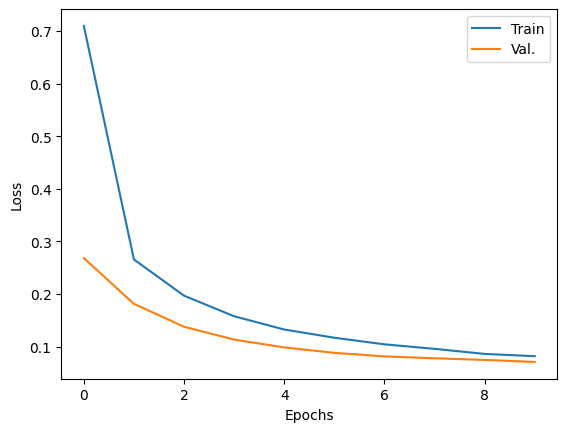

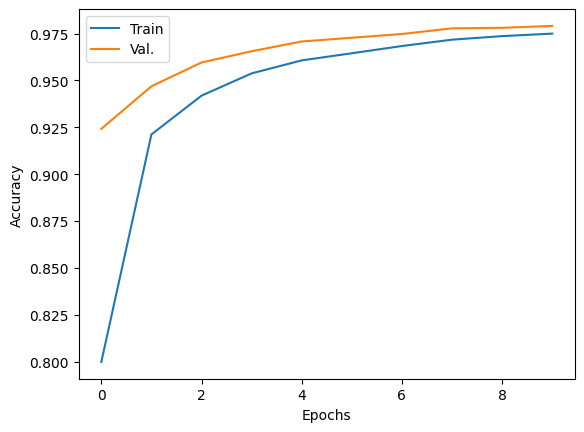

In [ ]:
# Learning curves

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

plt.plot(range(len(train_accs)), train_accs)
plt.plot(range(len(val_accs)), val_accs)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()